In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings

from tqdm.auto import tqdm
import itertools
import matplotlib as mpl
import scipy
# from scipy.integrate import cumtrapz
import seaborn as sns
import os
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

import re

import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS
import jax.numpy as jnp
import jax.random as random
import arviz as az

import chart_studio.plotly as py
import chart_studio
import json

import rpgf3lib

warnings.simplefilter(action='ignore', category=UserWarning)

/home/kiran/code/fil-retropgf/rpgf3/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
QUORUM = 4
TOTAL_FUNDING = 510000
MIN_FUNDING = 500
SCORING_FN = 'sum'

In [4]:
# Normalize Project Names: use the best version (without replacement characters) for each Application ID
df = pd.read_csv('../data/ballots-fil-retropgf-3-deidentified.csv')

# First, normalize whitespace and special characters
df['Project Name Normalized'] = (
    df['Project Name']
    .str.strip()
    .str.replace('–', '-', regex=False)
    .str.replace('\'', "'", regex=False)
)

# Create a mapping: for each Application ID, use the first Project Name that doesn't contain
# If all contain, use the first one
def get_canonical_name(group):
    # Prefer names without replacement character
    without_replacement = group[~group['Project Name Normalized'].str.contains('', na=False)]
    if len(without_replacement) > 0:
        return without_replacement.iloc[0]['Project Name Normalized']
    else:
        return group.iloc[0]['Project Name Normalized']

canonical_names = df.groupby('Application ID').apply(get_canonical_name).to_dict()

# Apply the canonical name to all rows
df['Project Name Canonical'] = df['Application ID'].map(canonical_names)

# Verify: check if there are still conflicts after using canonical names
app_id_groups = df.groupby('Application ID')['Project Name Canonical'].nunique()
conflicting = app_id_groups[app_id_groups > 1].index

if len(conflicting) > 0:
    print("Still have conflicts after canonicalization:")
    display(df[df['Application ID'].isin(conflicting)][['Application ID', 'Project Name', 'Project Name Canonical']].drop_duplicates())
else:
    print(f"✓ Successfully normalized: {len(canonical_names)} unique Application IDs")
    print(f"✓ All Application IDs now have unique canonical Project Names")

✓ Successfully normalized: 120 unique Application IDs
✓ All Application IDs now have unique canonical Project Names


/tmp/ipykernel_61687/1479564253.py:22: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  canonical_names = df.groupby('Application ID').apply(get_canonical_name).to_dict()


In [5]:
df

,Voter Wallet Address,Application ID,Project Name,Assigned votes,Project Name Normalized,Project Name Canonical
0,Badgeholder 1,1f64b8a1-bdbe-4068-8711-603b6624fb58,Forest,25000,Forest,Forest
1,Badgeholder 1,28288464-b209-4206-84ac-d3d47b340169,Spacescope: API service for the Filecoin ecosy...,30000,Spacescope: API service for the Filecoin ecosy...,Spacescope: API service for the Filecoin ecosy...
2,Badgeholder 1,2bd98798-00fc-4ee2-846b-543627dfae0c,Beryx Filecoin API,20000,Beryx Filecoin API,Beryx Filecoin API
3,Badgeholder 1,32c9890d-111f-4652-92ae-4d538018f11c,Secured Finance,60000,Secured Finance,Secured Finance
4,Badgeholder 1,4499d1d8-a659-41f0-a8ee-845813d3c316,Blockscout Open Source Filecoin Explorer,20000,Blockscout Open Source Filecoin Explorer,Blockscout Open Source Filecoin Explorer
...,...,...,...,...,...,...
946,Badgeholder 30,940de67a-f153-4633-8193-27952a1ac9e3,Ancients Research,4895,Ancients Research,Ancients Research
947,Badgeholder 30,7a4f6567-20bf-4ae0-a918-b79ab5ce1758,Multichain Storage,3969,Multichain Storage,Multichain Storage
948,Badgeholder 30,1855e0c8-6176-4492-9966-535738b38084,Cuview,5821,Cuview,Cuview
949,Badgeholder 30,59c4afee-5d3c-4c21-9977-4d0b88406bd2,Cyberport Data Integration,2740,Cyberport Data Integration,Cyberport Data Integration


In [6]:
NUM_VOTERS = df['Voter Wallet Address'].nunique()
print(f'Number of voters: {NUM_VOTERS}')


Number of voters: 30


In [7]:
dff = df[['Voter Wallet Address', 'Application ID', 'Project Name Canonical', 'Assigned votes']]
dff.rename(columns={
    'Voter Wallet Address': 'voterId',
    'Application ID': 'projectId', 
    'Project Name Canonical': 'project',
    'Assigned votes': 'amount'
    }, 
inplace=True)
dff.head()

# dff.to_csv('../data/project_names.csv', index=False)


/tmp/ipykernel_61687/3305430997.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dff.rename(columns={


,voterId,projectId,project,amount
0,Badgeholder 1,1f64b8a1-bdbe-4068-8711-603b6624fb58,Forest,25000
1,Badgeholder 1,28288464-b209-4206-84ac-d3d47b340169,Spacescope: API service for the Filecoin ecosy...,30000
2,Badgeholder 1,2bd98798-00fc-4ee2-846b-543627dfae0c,Beryx Filecoin API,20000
3,Badgeholder 1,32c9890d-111f-4652-92ae-4d538018f11c,Secured Finance,60000
4,Badgeholder 1,4499d1d8-a659-41f0-a8ee-845813d3c316,Blockscout Open Source Filecoin Explorer,20000


In [8]:
category_df = pd.read_csv('../data/project2cat.csv')
category_df.rename(columns={
    'Project Name': 'project',
    'Category Name': 'impactCategory'}, 
inplace=True)
category_df = category_df[['project', 'impactCategory']]

# Normalize project names in category_df the same way as in the ballots
# Use Unicode escapes for special characters to avoid parsing issues
en_dash = '\u2013'  # en dash
right_single_quote = '\u2019'  # right single quotation mark
category_df['project_normalized'] = (
    category_df['project']
    .str.strip()
    .str.replace(en_dash, '-', regex=False)
    .str.replace(right_single_quote, "'", regex=False)
)

# Create a mapping from normalized names to canonical names using the df dataframe
# This maps any normalized variation to its canonical name
normalized_to_canonical = df[['Project Name Normalized', 'Project Name Canonical']].drop_duplicates()
normalized_to_canonical = dict(zip(normalized_to_canonical['Project Name Normalized'], 
                                   normalized_to_canonical['Project Name Canonical']))

# Map normalized category_df project names to canonical names
category_df['project'] = category_df['project_normalized'].map(normalized_to_canonical).fillna(category_df['project_normalized'])
category_df = category_df[['project', 'impactCategory']]  # Drop the temporary normalized column

# Rename categories
category_df.loc[category_df['impactCategory'] == 'Education and Outreach', 'impactCategory'] = 'Edu & Outreach'
category_df.loc[category_df['impactCategory'] == 'Tooling and Utilities', 'impactCategory'] = 'Tooling & Utilities'
category_df.loc[category_df['impactCategory'] == 'Collective Governance', 'impactCategory'] = 'Governance'
category_df.loc[category_df['impactCategory'] == 'Infrastructure and Dependencies', 'impactCategory'] = 'Infra & Deps'
category_df.loc[category_df['impactCategory'] == 'Protocol Research & Development', 'impactCategory'] = 'Protocol R&D'
category_df.loc[category_df['impactCategory'] == 'Products and End User UX', 'impactCategory'] = 'Product & UX'

In [9]:
dff = dff.merge(category_df, on='project', how='left')
dff.rename(columns={'impactCategory': 'category'}, inplace=True)

In [10]:
dff.head()

,voterId,projectId,project,amount,category
0,Badgeholder 1,1f64b8a1-bdbe-4068-8711-603b6624fb58,Forest,25000,Infra & Deps
1,Badgeholder 1,28288464-b209-4206-84ac-d3d47b340169,Spacescope: API service for the Filecoin ecosy...,30000,Tooling & Utilities
2,Badgeholder 1,2bd98798-00fc-4ee2-846b-543627dfae0c,Beryx Filecoin API,20000,Tooling & Utilities
3,Badgeholder 1,32c9890d-111f-4652-92ae-4d538018f11c,Secured Finance,60000,Infra & Deps
4,Badgeholder 1,4499d1d8-a659-41f0-a8ee-845813d3c316,Blockscout Open Source Filecoin Explorer,20000,Infra & Deps


In [11]:
# get nan category projects
nan_category_projects = dff[dff['category'].isna()]['project'].unique()
print(f'Number of projects with no category: {len(nan_category_projects)}')
# print the projects
print(nan_category_projects)

Number of projects with no category: 2
['GainForest: The world’s first community-owned data commons for nature impact'
 'Oku.trade - Filecoin’s premier DeFi aggregator for deep liquidity, LP management and cross-chain interoperability - 0% fee swaps & bridges.']


In [12]:
# manually add category for these projects
dff.loc[dff['project'] == 'GainForest: The world’s first community-owned data commons for nature impact', 'category'] = 'Product & UX'
dff.loc[dff['project'] == 'Oku.trade - Filecoin’s premier DeFi aggregator for deep liquidity, LP management and cross-chain interoperability - 0% fee swaps & bridges.', 'category'] = 'Product & UX'

In [13]:
# get nan category projects
nan_category_projects = dff[dff['category'].isna()]['project'].unique()
print(f'Number of projects with no category: {len(nan_category_projects)}')
# print the projects
print(nan_category_projects)

Number of projects with no category: 0
[]


In [14]:
projectid2name = {}
projectname2id = {}
for i, row in dff.iterrows():
    projectid2name[row['projectId']] = row['project']
    projectname2id[row['project']] = row['projectId']

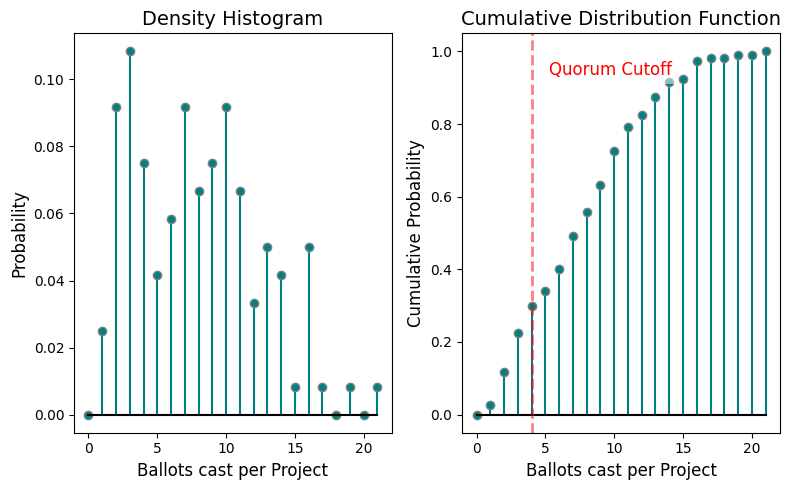

In [15]:
rpgf3lib.votes_distribution_stem(dff, quorum_cutoff=QUORUM, save_fp='../figures/votes_distribution.png')

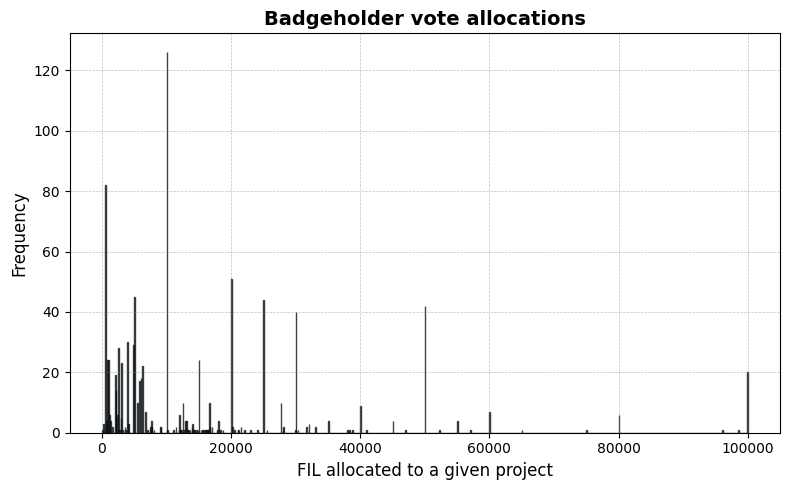

In [16]:
rpgf3lib.votes_per_project_histogram(dff, save_fp='../figures/votes_per_project.png')

In [17]:
dff['amount'].value_counts()

amount
10000    126
500       82
20000     51
5000      45
25000     44
        ... 
23000      1
65000      1
47000      1
0          1
2740       1
Name: count, Length: 135, dtype: int64

In [18]:
allocations, eliminated, reasons, stats, failed_df, success_df = rpgf3lib.run_allocation_analysis(
    dff,
    quorum_cutoff=QUORUM,
    min_funding=MIN_FUNDING,
    total_funding=TOTAL_FUNDING,
    project_names=projectid2name,
    scoring_fn='sum',
    verbose=False
)

In [19]:
print(f'Failed {len(failed_df)} projects')
print(f'Success {len(success_df)} projects')
print(f'Total {len(dff.groupby("projectId").size())} projects')

Failed 29 projects
Success 91 projects
Total 120 projects


In [20]:
failed_df.to_csv('../data/failed_projects.csv', index=False)
success_df.to_csv('../data/successful_projects.csv', index=False)

In [21]:
failed_df

,Project Name,Vote Count,Score,Round,Reason,category
0,FILCAPETOWN,1,2118,1,Failed quorum with 1 votes,Edu & Outreach
1,OP Medicine - Filecoin-Powered Healthcare Infr...,3,22618,1,Failed quorum with 3 votes,Infra & Deps
2,B<>rder/ess Developers Program,3,15969,1,Failed quorum with 3 votes,Edu & Outreach
3,IPFS及Filecoin价值资讯传递（南山居士Hill）,2,6895,1,Failed quorum with 2 votes,Edu & Outreach
4,boxo-starter-kit,4,11895,1,Failed minimum funding with 417.06,Edu & Outreach
5,OpenEdStore Decentralized Educational Storage ...,1,2118,1,Failed quorum with 1 votes,Tooling & Utilities
6,Filecoin Kenya Community,3,22618,1,Failed quorum with 3 votes,Edu & Outreach
7,Cyberport Data Integration,2,17740,1,Failed quorum with 2 votes,Governance
8,Guide To Filecoin - Easing the Transition to F...,2,8044,1,Failed quorum with 2 votes,Edu & Outreach
9,ETH-FIL swap,2,2618,1,Failed quorum with 2 votes,Tooling & Utilities


In [22]:
list(success_df['Project Name'].unique())

['Filecoin Onchain Cloud (FOC) - Verifiable Storage, Retrieval, and Payments',
 'FIL-B (FIL Builders) DX and Community',
 'FilOz - Advancing the Filecoin Protocol',
 'go-libp2p',
 'Filecoin Data Portal',
 'Curio Storage',
 'drand - the distributed randomness beacon project powering the League of Entropy and Filecoin Leader Election',
 'UCAN',
 'Secured Finance',
 'FilPonto: Public goods chain infrastructure & collaborations support for Filecoin',
 'Lotus, Builtin Actors, and ref-FVM - Core Filecoin Protocol Implementations',
 'Filscan Explorer',
 'Crossfi',
 'ND Labs',
 'Filliquid',
 'Eastore',
 'Lily: blockchain data extraction for Filecoin',
 'Beryx Filecoin Explorer',
 'Blockscout Open Source Filecoin Explorer',
 'Beryx Filecoin API',
 'Chain.Love',
 'Lighthouse',
 'Forest',
 'FIP Editors - Filecoin Improvement Proposal Governance',
 'filecoin-checker',
 'Asia-SPWG',
 'Filecoin Beam',
 'Boost',
 'Drips',
 'Old Faithful',
 'chainfee',
 'OrbitChina',
 'FIP 100 Research & Development',

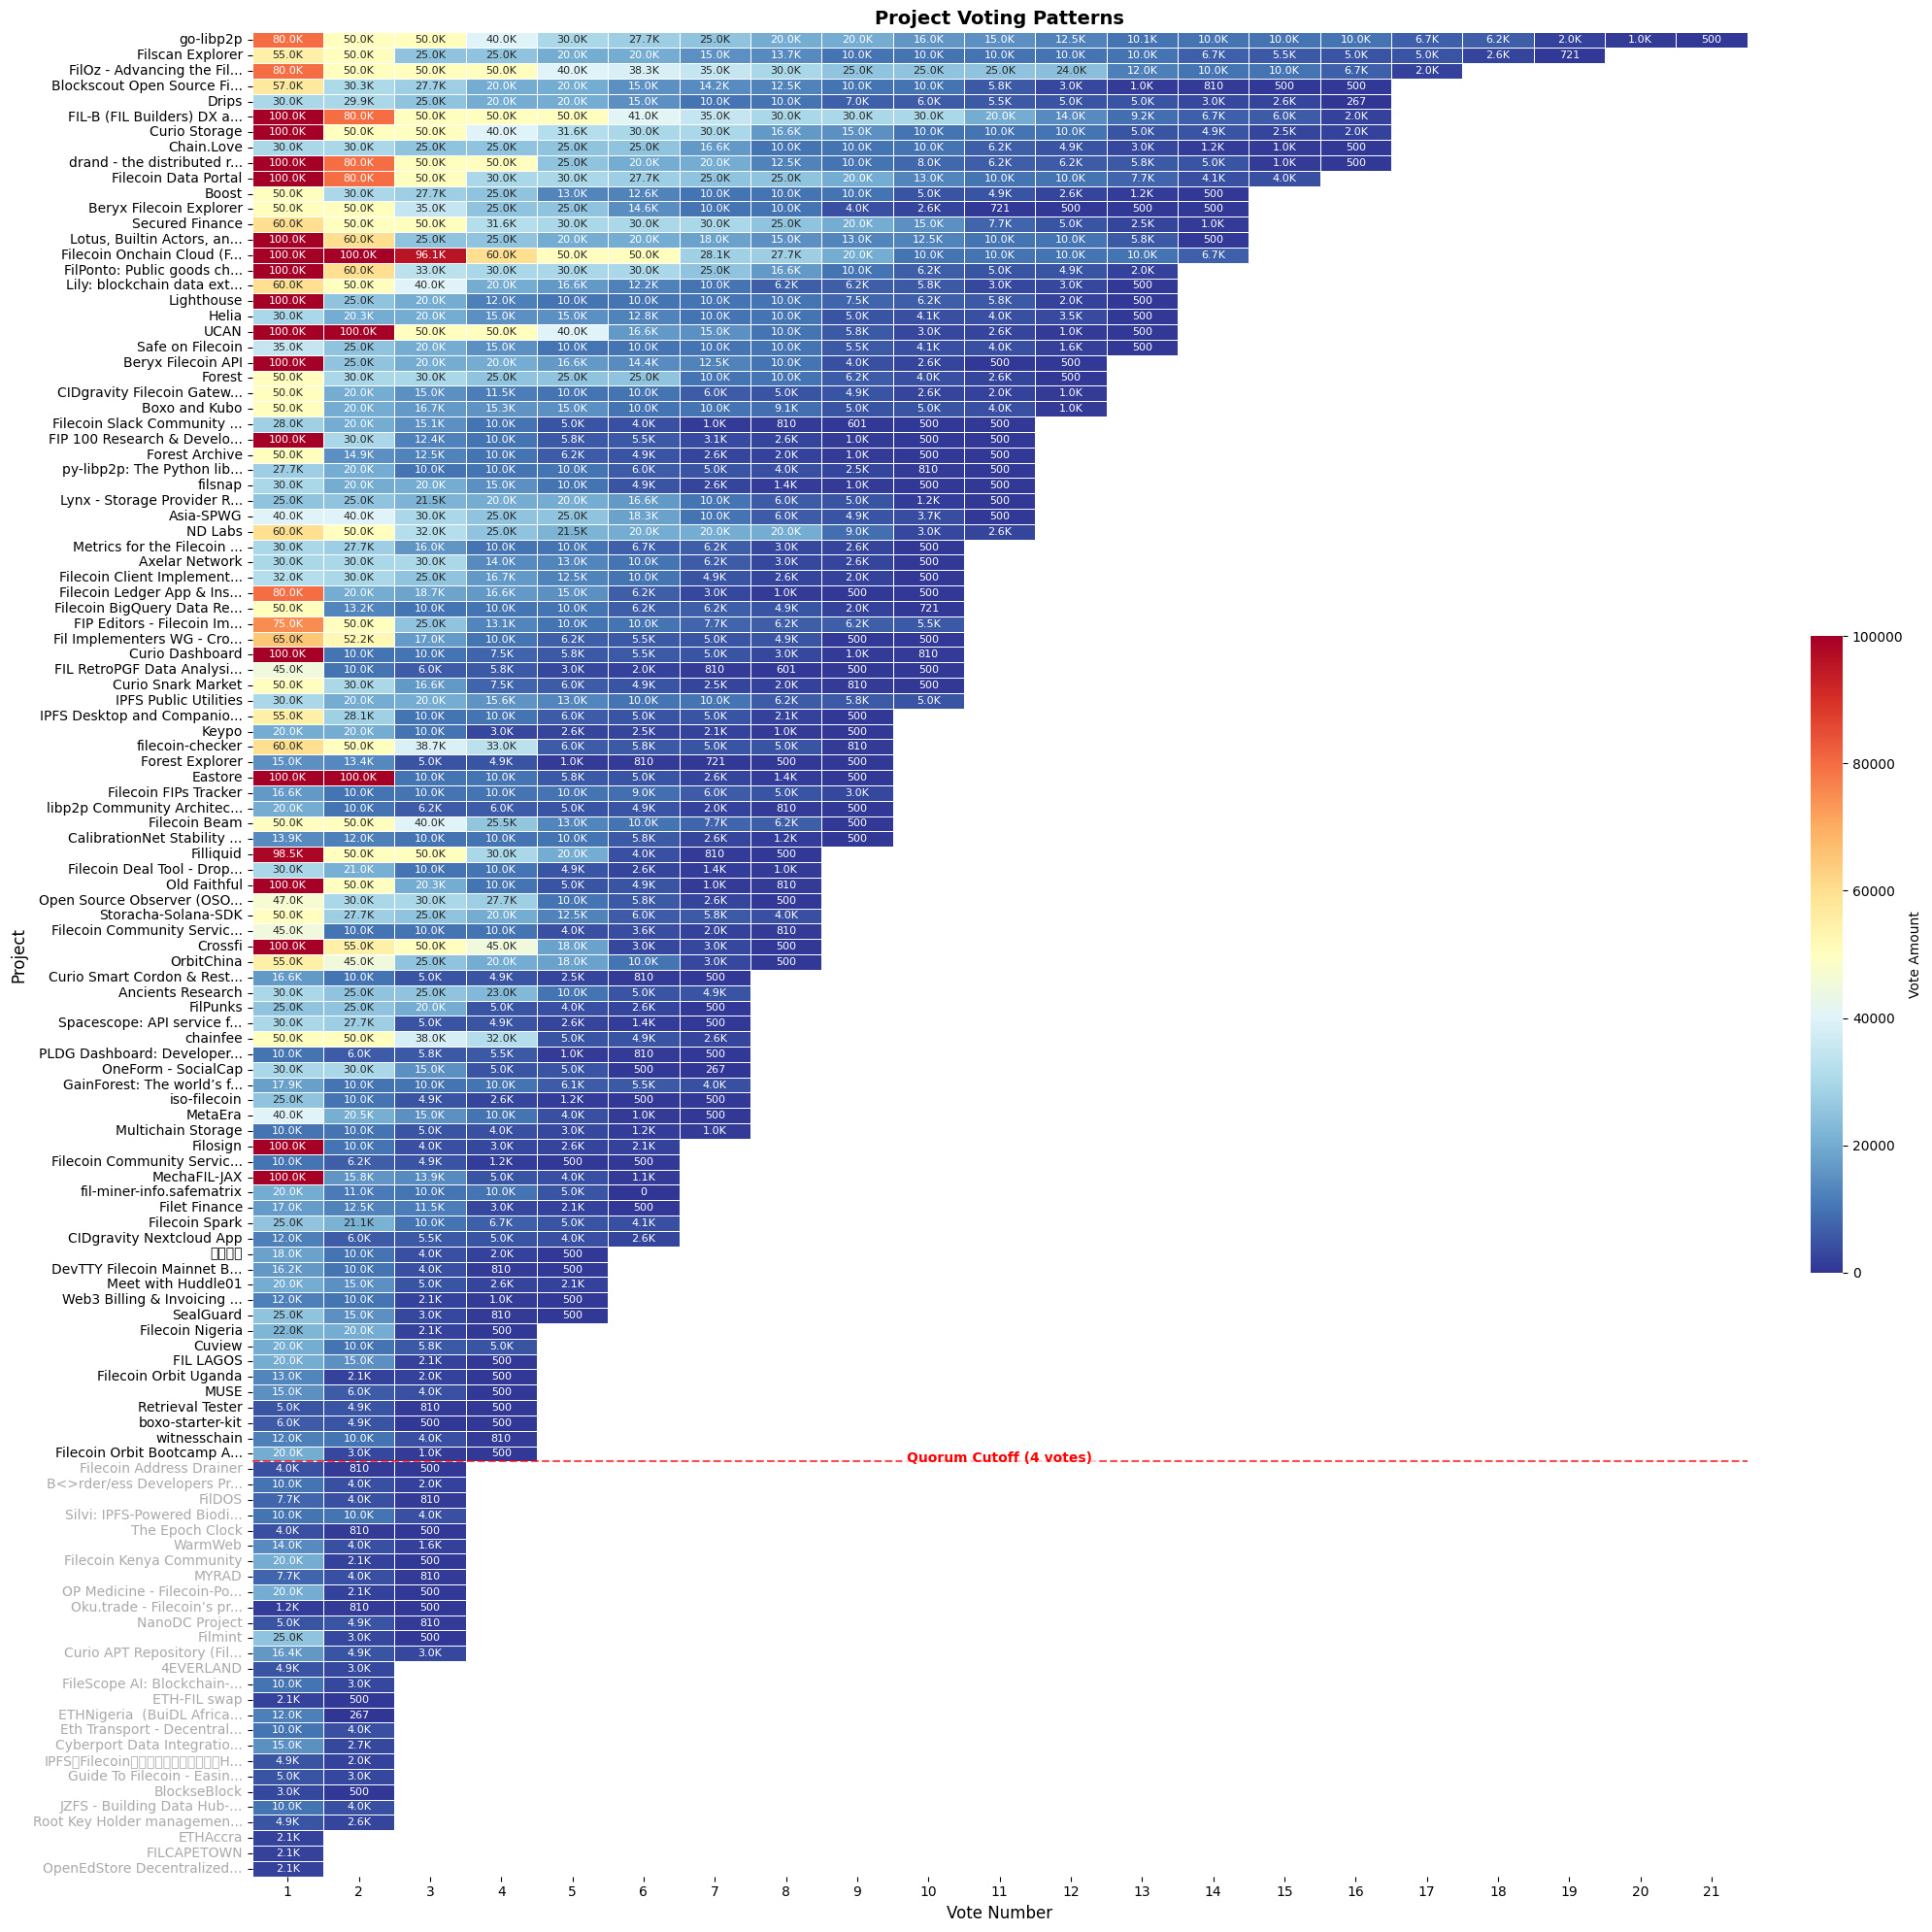

In [23]:
rpgf3lib.project_patterns_withname(
    dff, 
    figsize=(20, 20), 
    save_fp='../figures/project_patterns.png',
    quorum_threshold=QUORUM
)

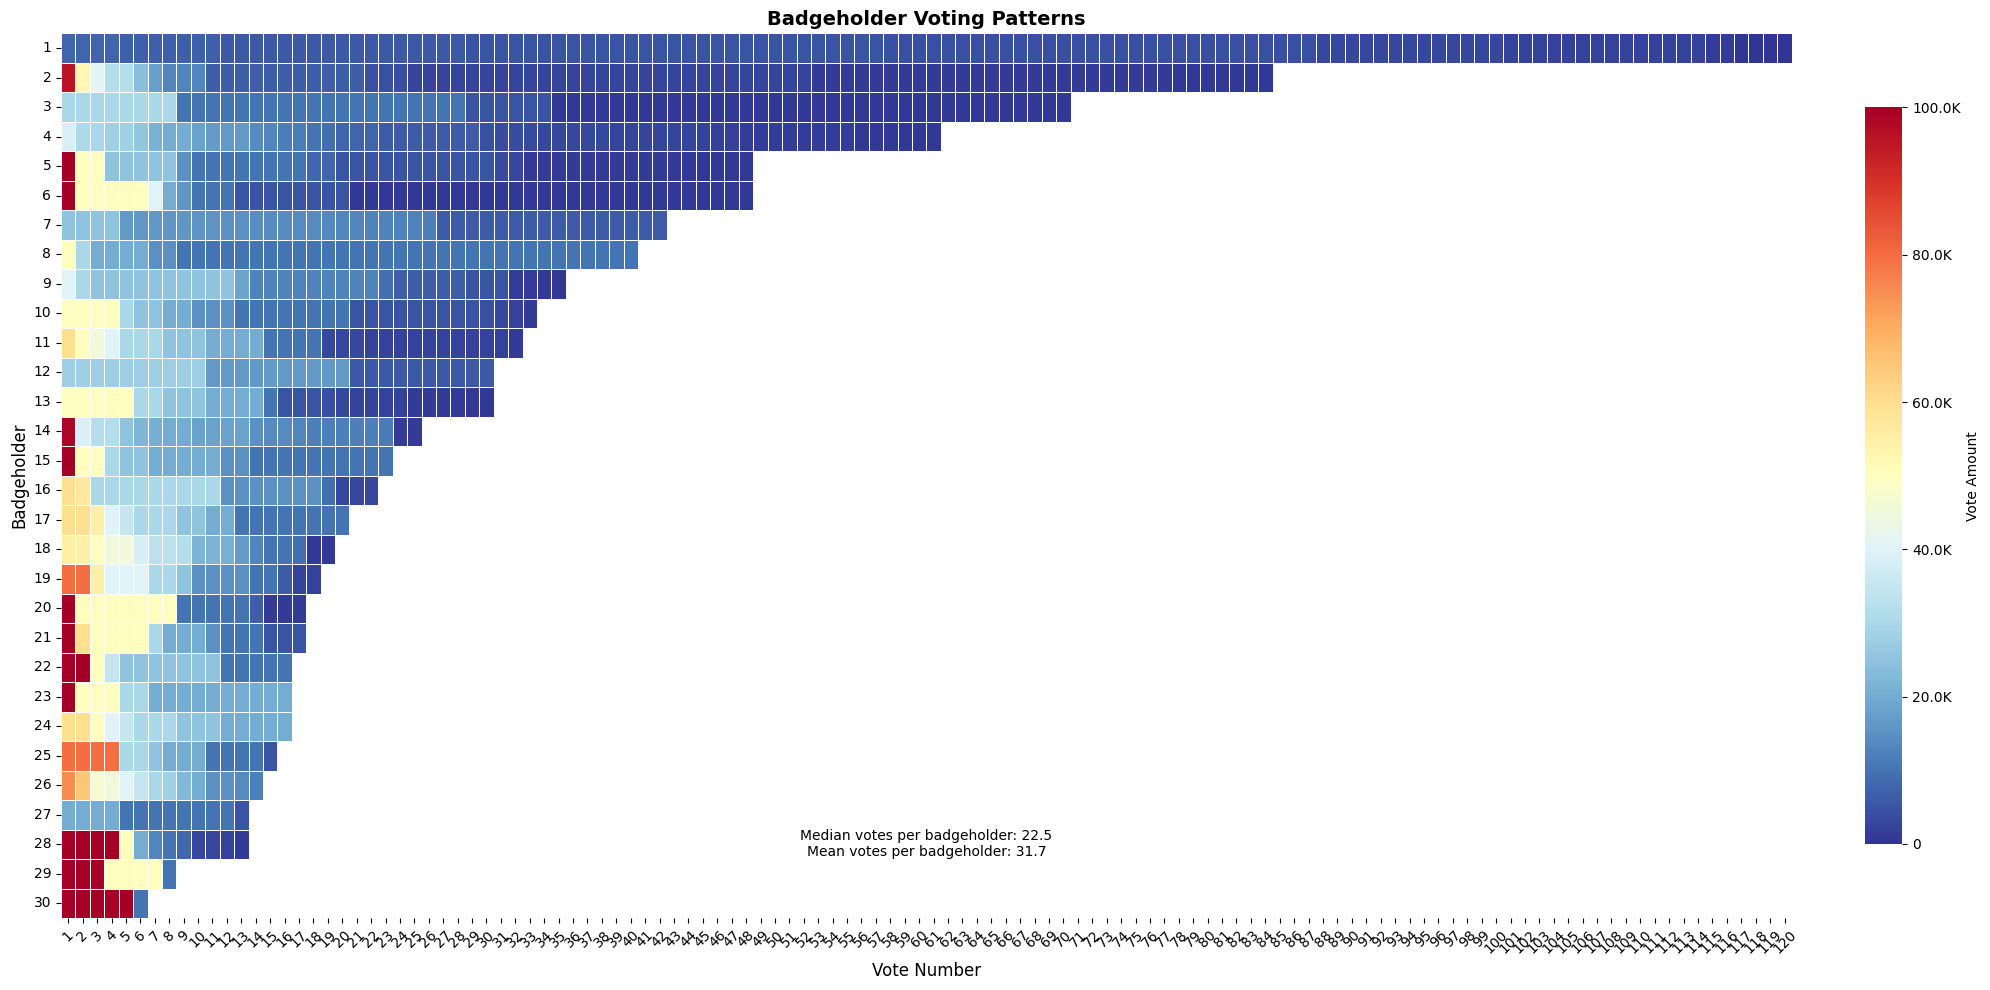

In [24]:
rpgf3lib.badgeholder_patterns2(dff, figsize=(20, 10), save_fp='../figures/badgeholder_patterns.png')

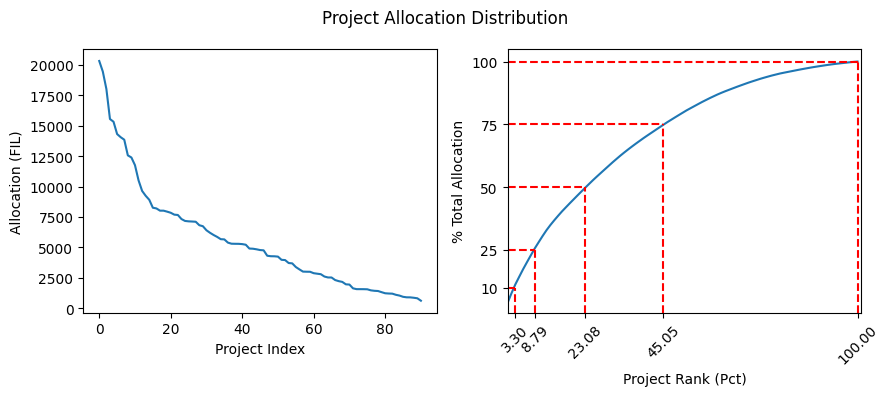

In [25]:
rpgf3lib.project_distribution_patterns(allocations, figsize=(9,4), save_fp='../figures/project_distribution.png')

In [26]:
upload_to_plotly = False

plotly_fig = rpgf3lib.plot_allocations_sunburst(success_df, 
                                                show_project_labels=True,
                                                save_fp='../figures/rpgf3_project_allocations.png')
plotly_fig.show()
if upload_to_plotly:
    with open(os.path.join(os.environ['HOME'], 'code', 'cel', 'auth', 'plotly.json'), 'r') as fp:
        plotly_auth = json.load(fp)
    chart_studio.tools.set_credentials_file(username=plotly_auth['username'], api_key=plotly_auth['api_key'])
    py.plot(plotly_fig, filename='rpgf2_project_allocations', auto_open=True)

Input DataFrame shape: (91, 6)
DataFrame columns: ['Project Name', 'Vote Count', 'Average Score', 'Std Dev', 'Final Allocation (FIL)', 'category']
Sample of input data:
                                         Project Name  Vote Count  \
81  Filecoin Onchain Cloud (FOC) - Verifiable Stor...          14   
28              FIL-B (FIL Builders) DX and Community          16   
42            FilOz - Advancing the Filecoin Protocol          17   
22                                          go-libp2p          21   
64                               Filecoin Data Portal          15   

    Average Score  Std Dev  Final Allocation (FIL)             category  
81       41332.00 35426.63                20320.65  Tooling & Utilities  
28       34617.94 27195.70                19451.11       Edu & Outreach  
42       30180.53 20082.92                18017.68         Protocol R&D  
22       21087.95 19854.64                15551.66         Infra & Deps  
64       29094.80 27877.38                1532

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

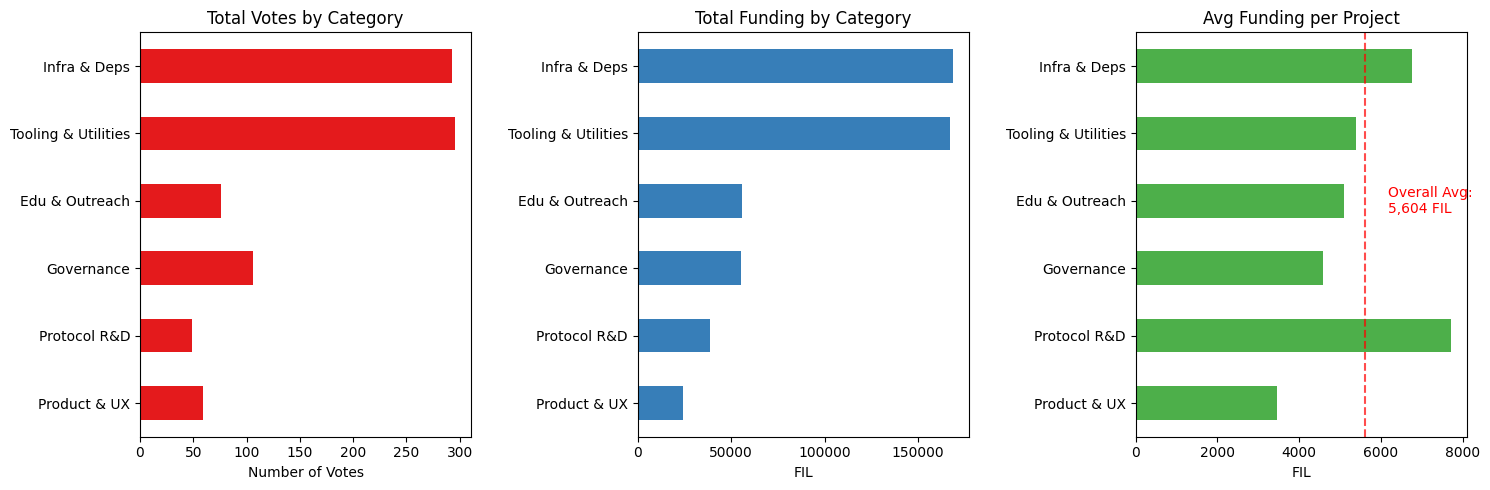

In [27]:
f = rpgf3lib.plot_category_metrics(
    success_df, 
    style='bar',
    save_fp='../figures/category_metrics.png'
)

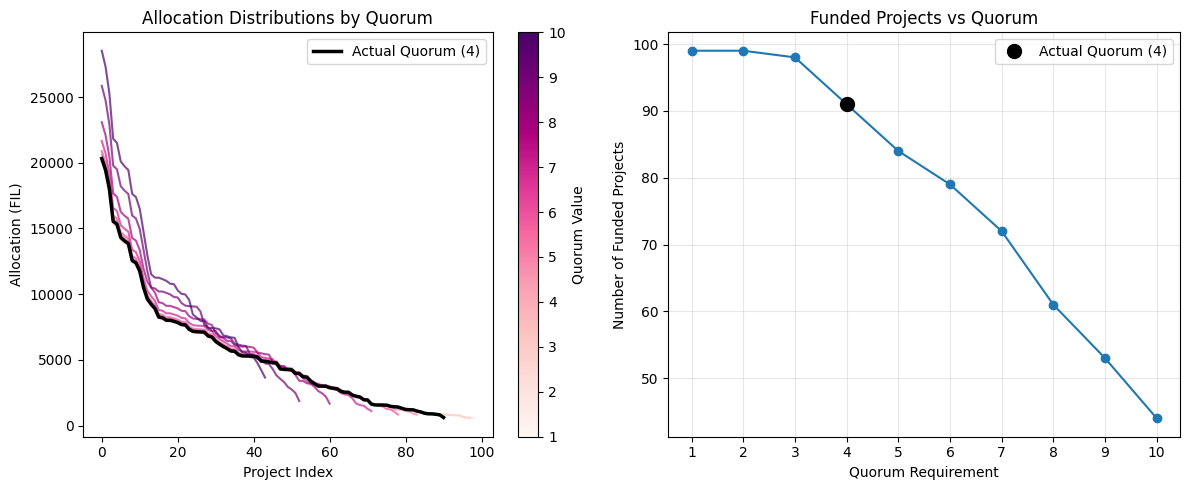

In [28]:
f = rpgf3lib.plot_quorum_sweep(
    dff, 
    actual_quorum=QUORUM,
    min_funding=MIN_FUNDING,
    total_funding=TOTAL_FUNDING,
    save_fp='../figures/quorum_sweep.png'
)


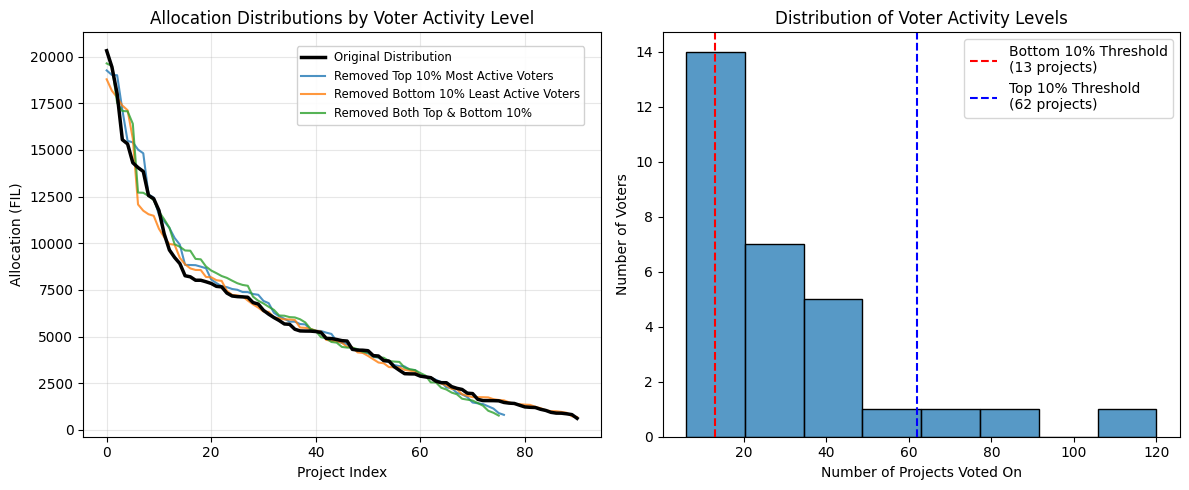

In [29]:
f = rpgf3lib.plot_temperature_analysis(
    dff, 
    quorum_cutoff=QUORUM,
    min_funding=MIN_FUNDING,
    total_funding=TOTAL_FUNDING,
    save_fp='../figures/temperature_analysis.png'
)


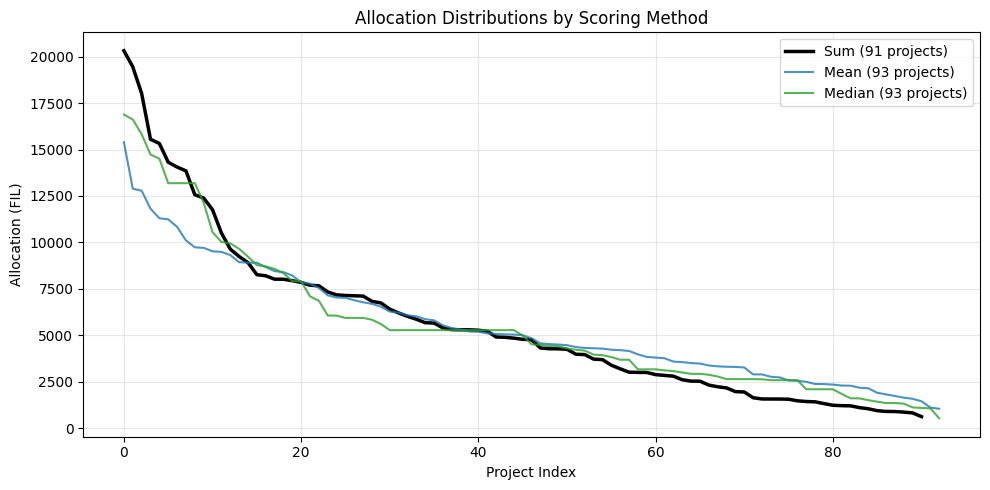

In [30]:
f = rpgf3lib.plot_scoring_comparison(
    dff, 
    quorum_cutoff=QUORUM,
    min_funding=MIN_FUNDING,
    total_funding=TOTAL_FUNDING,
    save_fp='../figures/scoring_comparison.png'
)

In [31]:
bootstrap_allocations = rpgf3lib.bootstrap_allocation_distribution(
    dff, 
    n_samples=1000,
    min_voters=28, 
    quorum_cutoff=QUORUM, 
    min_funding=MIN_FUNDING, 
    total_funding=TOTAL_FUNDING, 
    sample_size=None  # choose between min_voters and total voters randomly
)

100%|██████████| 1000/1000 [00:35<00:00, 28.33it/s]


In [32]:
print(len(bootstrap_allocations))

1000


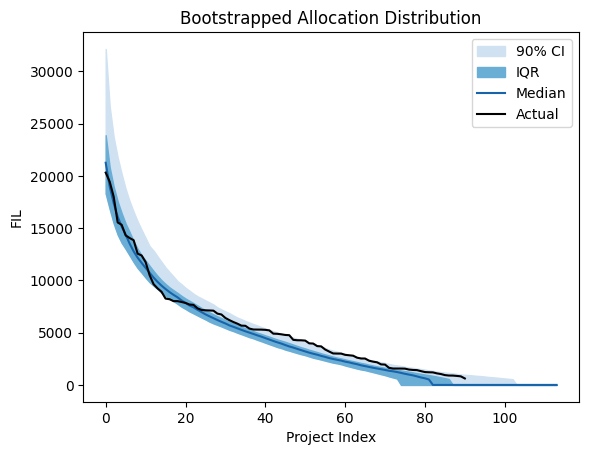

In [33]:
rpgf3lib.plot_bootstrap_distribution(
    bootstrap_allocations, 
    allocations, 
    save_fp='../figures/bootstrap_allocation_distribution.png'
)

In [34]:
success_df['PctOfTotal'] = success_df['Final Allocation (FIL)'] / success_df['Final Allocation (FIL)'].sum()*100
success_df.sort_values('PctOfTotal', ascending=False).head()
success_df.head()

,Project Name,Vote Count,Average Score,Std Dev,Final Allocation (FIL),category,PctOfTotal
81,Filecoin Onchain Cloud (FOC) - Verifiable Stor...,14,41332.00,35426.63,20320.65,Tooling & Utilities,3.98
28,FIL-B (FIL Builders) DX and Community,16,34617.94,27195.70,19451.11,Edu & Outreach,3.81
42,FilOz - Advancing the Filecoin Protocol,17,30180.53,20082.92,18017.68,Protocol R&D,3.53
22,go-libp2p,21,21087.95,19854.64,15551.66,Infra & Deps,3.05
64,Filecoin Data Portal,15,29094.80,27877.38,15326.03,Infra & Deps,3.01


In [35]:
xx = success_df.head()
xx['PctOfTotal'].sum()

np.float64(17.38571279740274)

In [36]:
success_df['Final Allocation (FIL)'].describe()


count      91.00
mean     5604.40
std      4448.84
min       618.70
25%      2196.61
50%      4782.58
75%      7498.23
max     20320.65
Name: Final Allocation (FIL), dtype: float64

In [37]:
success_df['Final Allocation (FIL)'].median()

np.float64(4782.577110891792)

In [38]:
success_df.sort_values('Vote Count', ascending=False).head()

,Project Name,Vote Count,Average Score,Std Dev,Final Allocation (FIL),category,PctOfTotal
22,go-libp2p,21,21087.95,19854.64,15551.66,Infra & Deps,3.05
88,Filscan Explorer,19,15750.05,14733.29,10508.94,Tooling & Utilities,2.06
42,FilOz - Advancing the Filecoin Protocol,17,30180.53,20082.92,18017.68,Protocol R&D,3.53
25,drand - the distributed randomness beacon proj...,16,25017.75,29742.05,14056.96,Infra & Deps,2.76
52,Curio Storage,16,25478.75,25658.30,14315.99,Infra & Deps,2.81


In [ ]:
position_analysis_df = success_df[['Project Name', 'Vote Count', 'Final Allocation (FIL)']]
position_analysis_df['projects_alphabet_pos'] = position_analysis_df['Project Name'].apply(lambda x: ord(x.strip()[0].lower()) - ord('a'))

In [ ]:
def correlation_model_votes(x, y):
    # Priors for means and standard deviations of x and y
    mu_x = numpyro.sample('mu_x', dist.Normal(0, 10))
    sigma_x = numpyro.sample('sigma_x', dist.Exponential(1))
    
    mu_y = numpyro.sample('mu_y', dist.Normal(0, 10))
    sigma_y = numpyro.sample('sigma_y', dist.Exponential(1))
    
    # Prior for the correlation coefficient
    rho = numpyro.sample('rho', dist.Uniform(-1, 1))
    
    # Covariance matrix
    covariance = jnp.array([
        [sigma_x**2, rho * sigma_x * sigma_y],
        [rho * sigma_x * sigma_y, sigma_y**2]
    ])
    
    # Sampling from a bivariate normal distribution
    numpyro.sample('obs', dist.MultivariateNormal(loc=jnp.array([mu_x, mu_y]), covariance_matrix=covariance), obs=jnp.column_stack((x, y)))

def correlation_model_allocation(x, y):
    # Adjust priors to match the scale of the data
    mu_x = numpyro.sample('mu_x', dist.Normal(np.mean(x), 10))
    sigma_x = numpyro.sample('sigma_x', dist.Exponential(1))
    
    # Use more appropriate priors for y given the scale of allocations
    mu_y = numpyro.sample('mu_y', dist.Normal(np.mean(y), 1000))  # Increased scale
    sigma_y = numpyro.sample('sigma_y', dist.Exponential(1000))  # Increased scale
    
    # Prior for the correlation coefficient
    rho = numpyro.sample('rho', dist.Uniform(-1, 1))
    
    # Covariance matrix
    covariance = jnp.array([
        [sigma_x**2, rho * sigma_x * sigma_y],
        [rho * sigma_x * sigma_y, sigma_y**2]
    ])
    
    # Sampling from a bivariate normal distribution
    numpyro.sample('obs', dist.MultivariateNormal(loc=jnp.array([mu_x, mu_y]), covariance_matrix=covariance), obs=jnp.column_stack((x, y)))

In [ ]:
nuts_kernel = NUTS(correlation_model_votes)
mcmc = MCMC(nuts_kernel, num_warmup=500, num_samples=1000)

# Run MCMC
rng_key = random.PRNGKey(0)
x_data = position_analysis_df['projects_alphabet_pos'].values
y1_data = position_analysis_df['Vote Count'].values  # Use unsorted Vote Count
mcmc.run(rng_key, x=jnp.array(x_data), y=jnp.array(y1_data))

# mcmc.print_summary()
posterior_samples_votes = mcmc.get_samples()
rho_samples_votes = posterior_samples_votes['rho']

print(f"Modelled Pearson correlation coefficient of {np.mean(rho_samples_votes):.2f}")
print(f"With 95% credible intervals of the correlation coefficient being between {np.percentile(rho_samples_votes,5):.2f} and {np.percentile(rho_samples_votes,95):.2f}")

In [ ]:
nuts_kernel = NUTS(correlation_model_allocation)
n_samples = 1000
mcmc = MCMC(nuts_kernel, num_warmup=500, num_samples=n_samples)

# Run MCMC
rng_key = random.PRNGKey(0)
x_data = position_analysis_df['projects_alphabet_pos'].values
y2_data = position_analysis_df['Final Allocation (FIL)'].values  # Use unsorted Vote Count
mcmc.run(rng_key, x=jnp.array(x_data), y=jnp.array(y2_data))

# mcmc.print_summary()
posterior_samples_funding = mcmc.get_samples()
rho_samples_funding = posterior_samples_funding['rho']

print(f"Modelled Pearson correlation coefficient of {np.mean(rho_samples_funding):.2f}")
print(f"With 95% credible intervals of the correlation coefficient being between {np.percentile(rho_samples_funding,5):.2f} and {np.percentile(rho_samples_funding,95):.2f}")

In [ ]:
# Create figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))

# Create letter labels for x-axis
unique_positions = sorted(position_analysis_df['projects_alphabet_pos'].unique())
letter_labels = [chr(int(pos) + ord('A')) for pos in unique_positions]

# Left plot - Votes
x_data = position_analysis_df['projects_alphabet_pos'].values
y1_data = position_analysis_df['Vote Count'].values

# Generate lines for votes plot
x_line = np.linspace(min(x_data), max(x_data), 100)
y1_lines = []
for i in range(n_samples):
    rho = posterior_samples_votes['rho'][i]
    mu_x = posterior_samples_votes['mu_x'][i]
    mu_y = posterior_samples_votes['mu_y'][i]
    sigma_x = posterior_samples_votes['sigma_x'][i]
    sigma_y = posterior_samples_votes['sigma_y'][i]
    
    beta = rho * sigma_y / sigma_x
    y = mu_y + beta * (x_line - mu_x)
    y1_lines.append(y)

y1_lines = np.array(y1_lines)
y1_mean = np.mean(y1_lines, axis=0)
y1_lower = np.percentile(y1_lines, 2.5, axis=0)
y1_upper = np.percentile(y1_lines, 97.5, axis=0)

# Plot votes
ax1.scatter(x_data, y1_data, alpha=0.5, label='Data')
ax1.plot(x_line, y1_mean, color='red', label='Posterior Mean Regression')
ax1.fill_between(x_line, y1_lower, y1_upper, color='red', alpha=0.2, label='95% Credible Interval')

correlation_text = (f"Correlation: {np.mean(posterior_samples_votes['rho']):.2f}\n"
                   f"95% CI: [{np.percentile(posterior_samples_votes['rho'],5):.2f}, "
                   f"{np.percentile(posterior_samples_votes['rho'],95):.2f}]")
ax1.text(0.05, 0.95, correlation_text, transform=ax1.transAxes, 
         bbox=dict(facecolor='white', alpha=0.8), verticalalignment='top')

ax1.set_xticks(unique_positions)
ax1.set_xticklabels(letter_labels)
ax1.set_xlabel('Project First Letter')
ax1.set_ylabel('Number of Votes')
ax1.set_title('Project First Letter vs Number of Votes')
ax1.grid(True, alpha=0.3)
ax1.legend()

# Right plot - Funding
y2_data = position_analysis_df['Final Allocation (FIL)'].values

# Generate lines for funding plot
y2_lines = []
for i in range(n_samples):
    rho = posterior_samples_funding['rho'][i]
    mu_x = posterior_samples_funding['mu_x'][i]
    mu_y = posterior_samples_funding['mu_y'][i]
    sigma_x = posterior_samples_funding['sigma_x'][i]
    sigma_y = posterior_samples_funding['sigma_y'][i]
    
    beta = rho * sigma_y / sigma_x
    y = mu_y + beta * (x_line - mu_x)
    y2_lines.append(y)

y2_lines = np.array(y2_lines)
y2_mean = np.mean(y2_lines, axis=0)
y2_lower = np.percentile(y2_lines, 2.5, axis=0)
y2_upper = np.percentile(y2_lines, 97.5, axis=0)

# Plot funding
ax2.scatter(x_data, y2_data, alpha=0.5, label='Data')
ax2.plot(x_line, y2_mean, color='red', label='Posterior Mean Regression')
ax2.fill_between(x_line, y2_lower, y2_upper, color='red', alpha=0.2, label='95% Credible Interval')

correlation_text = (f"Correlation: {np.mean(posterior_samples_funding['rho']):.2f}\n"
                   f"95% CI: [{np.percentile(posterior_samples_funding['rho'],5):.2f}, "
                   f"{np.percentile(posterior_samples_funding['rho'],95):.2f}]")
ax2.text(0.05, 0.95, correlation_text, transform=ax2.transAxes, 
         bbox=dict(facecolor='white', alpha=0.8), verticalalignment='top')

ax2.set_xticks(unique_positions)
ax2.set_xticklabels(letter_labels)
ax2.set_xlabel('Project First Letter')
ax2.set_ylabel('Final Allocation (FIL)')
ax2.set_title('Project First Letter vs Funding')
ax2.grid(True, alpha=0.3)
ax2.legend()

plt.tight_layout()
plt.savefig('../figures/project_letter_vs_votes_and_funding.png', dpi=300)